In [1]:
# ML_in_Finance_Market_Impact
# Author: Matthew Dixon and Igor Halperin
# Version: 1.0 (14.10.2019)
# License: MIT
# Email: matthew.dixon@iit.edu
# Notes: tested on Mac OS X with Python 3.6.9 with the following packages:
# numpy=1.18.1, matplotlib=3.1.3, tqdm=4.46
# Citation: Please cite the following reference if this notebook is used for research purposes:
# Bilokon P., Dixon M.F. and I. Halperin, Machine Learning in Finance: From Theory to Practice, Springer Graduate textbook Series, 2020. 

In [7]:
!pip install tqdm

# The Market Making Problem

We can build on the previous two examples by considering the problem of high frequency market making. Unlike the previous example, we shall learn a time independent optimal policy.

Assume that a market maker seeks to capture the bid-ask spread by placing one lot best bid and ask limit orders. They are required to strictly keep their inventory between -1 and 1. The problem is when to optimally quote either a bid or ask, or simply wait, each time there is a limit order book update. For example, sometimes it may be more advantageous to quote a bid to close out a short position if it will almost surely give an instantaneous net reward, other times it may be better to wait and capture a larger spread.

In this toy example, the agent uses the liquidity imbalance in the top of the order book as a proxy for price movement and, hence, fill probabilities. The example does not use market orders, knowledge of queue positions, cancellations and limit order placement at different levels of the ladder. These are left to later material and exercises.

At each non-uniform time update, $t$, the market feed provides best prices and depths $\{p^a_t, q^a_t, p^b_t, q^b_t\}$. The state space is the product of the inventory, $X_t\in\{-1,0,1\}$, and gridded liquidity ratio $\hat{R}_t= \lfloor{\frac{q^a_t}{q^a_t+q^b_t}N\rfloor}\in [0,1]$, where $N$ is the number of grid points and $q^a_t$ and $q^b_t$ are the depths of the best ask and bid. $\hat{R}_t \rightarrow 0$ is the regime where the mid-price will go up and an ask is filled. Vice versa for $\hat{R}_t \rightarrow 1$. The dimension of the state space is chosen to be $ 3 \cdot 10 = 30$.

A bid is filled with probability $\epsilon_t:=\hat{R}_t$ and an ask is filled with probability $1-\epsilon_t$. The rewards are chosen to be the expected total P\&L. If a bid is filled to close out a short holding, then the expected reward $r_t=-\epsilon_t (\Delta p_t+c)$, where $\Delta p_t$ is the difference between the exit and entry price and $c$ is the transaction cost. For example, if the agent entered a short position at time $s<t$ with a filled ask at $p^a_s=100$ and closed out the position with a filled bid at $p^b_t=99$, then $\Delta p_t=1$. The agent is penalized for quoting an ask or bid when the position is already short or long respectively.

We can now apply SARSA or Q-learning to learn optimal market making in such a simplified setting. For exploration needed for on-line learning, one can use a
$\varepsilon $-greedy policy.

### Import the necessary libraries

In [11]:
!pip install pandas

  Using cached pytz-2021.1-py2.py3-none-any.whl (510 kB)


In [12]:
import time
import copy
import random
import sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from tqdm.notebook import tqdm 

In [2]:
%matplotlib inline

### Setting up  
#### Setting some global parameters  

Parameters of the reinforcement learning algorithms

In [42]:
EPSILON = 0.5 # Probability for exploration

ALPHA = 0.05 # Step size

GAMMA = 1 # Discount factor for Q-Learning and Sarsa

Some parameters describing the problem and our implementation of it

In [43]:
ACTIONS = [0, 1, 2] # Possible actions

NUM_INV_STEPS = 3 # Number of inventory states: long, short, flat

NUM_PROB_STEPS = 10 # Number of discrete probabilities

# Dimensions of the action-state value array:
Q_DIMS = (NUM_INV_STEPS, NUM_PROB_STEPS, len(ACTIONS))
#Q_DIMS = (NUM_INV_STEPS, NUM_PROB_STEPS, len(ACTIONS))

FILL_PROBS = np.linspace(0, 1, 10) # Possible probability values

c = 0 # Transaction cost

MAX_ITER = float('inf') # Maximum number of iterations in one episode
# (with `MAX_ITER = np.float('inf')`, the entire dataset will be used)

Note the discrete probability values in `FILL_PROBS`. These represent the probability of a bid being fulfilled, and the complement of the probability of an ask being fulfilled.

In [44]:
FILL_PROBS

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

These dictionaries map the names of the actions and positions to their index along the corresponding axis of the state-action value array `q_value` in the learning algorithms

In [45]:
actions = {'buy': 2, 'sell': 0, 'hold': 1} 
positions = {'flat': 0, 'long': 2, 'short': 1}

#### The data generator

The training data are in a .csv file. The data generator object yields the next Limit Order Book update from the file. When it reaches the end of the file, it raises `StopIteration`, and its `rewind()` method must be called to reset it.

In [46]:
class DataFeed(object):
    def __init__(self, data_RA):
        self.data_RA = data_RA
        self.rewind()
    def next(self):
        try:
            return self.__gen.__next__()
        except StopIteration as e:
            raise e
    def rewind(self):
        self.__gen = (row for row in self.data_RA)

In [47]:
t = pd.read_csv('../data/SBER20150310.csv')
t.head()

,Unnamed: 0,BidPrice5,BidVolume5,BidPrice4,BidVolume4,BidPrice3,BidVolume3,BidPrice2,BidVolume2,BidPrice1,...,EMA30,EMA100,STD10,STD50,STD100,STD1000,RSI14,RSI30,RSI50,RSI100
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,70.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,70.00,20.0,70.50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,70.0,20.0,70.50,880.0,72.45,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,0.0,70.0,20.0,70.5,880.0,72.23,10700.0,72.45,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,70.0,20.0,70.5,880.0,71.0,100.0,72.23,10700.0,72.45,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
data = t[['AskPrice1', 'AskVolume1', 'BidPrice1', 'BidVolume1']]
data.head()

,AskPrice1,AskVolume1,BidPrice1,BidVolume1
0,0.0,0.0,70.00,20.0
1,0.0,0.0,70.50,880.0
2,0.0,0.0,72.45,15000.0
3,0.0,0.0,72.45,15000.0
4,0.0,0.0,72.45,15000.0


In [49]:
np.array(data)

array([[    0.  ,     0.  ,    70.  ,    20.  ],
       [    0.  ,     0.  ,    70.5 ,   880.  ],
       [    0.  ,     0.  ,    72.45, 15000.  ],
       ...,
       [   69.98, 12620.  ,    69.89,  1980.  ],
       [   69.98, 12620.  ,    69.89,  1980.  ],
       [   69.98, 12620.  ,    69.89,  1980.  ]])

In [59]:
#csv_path = '../data/SBER20150310.csv'

#data_RA = np.genfromtxt(csv_path, delimiter=',', dtype=float)
#data_RA = pd.read_csv(csv_path)
data_RA = np.array(data)
data_generator = DataFeed(data_RA)

In [60]:
#csv_path = '../data/AMZN-L1.csv'

#data_RA = np.genfromtxt(csv_path, delimiter=',', dtype=float)
#data_generator = DataFeed(data_RA)

#### State
The state has four elements: 
- position (flat, long, short); 
- probability of ask fill (index in the array of probabilities)
- prices (a dictionary of bid and ask)
- entry price

We note, however, that the q-value is only a function of the position and probability, and the action taken.

Here, we define a function to "rewind" the data generator to the beginning of the dataset and initialise the state vector

In [61]:
def get_initial_state(data_generator):
    data_generator.rewind()
    
    # By convention we start with a flat position
    # and, therefore, no entry price
    position = positions['flat']
    entry_price = None
    
    ask, ask_depth, bid, bid_depth = data_generator.next()
    
    #price = {'bid': bid/1000.0, 'ask': ask/1000.0}  
    price = {'bid': bid, 'ask': ask}  
    
    # Estimate the fill probability
    q = bid_depth / (bid_depth + ask_depth)
    # Quantise q and scale it to the integer index 
    # q_ind is an index of the vector `FILL_PROBS`
    q_ind = int(q * NUM_PROB_STEPS) 
    
    initial_state = position, q_ind, price, entry_price
    
    return initial_state

In [62]:
START = get_initial_state(data_generator)
print(START)

(0, 10, {'bid': 70.0, 'ask': 0.0}, None)


#### Setting up the environment

The step function that describes how the next state is obtained from the current state and the action taken. 

The function returns the next state and the immediate reward obtained from the action taken. 

In [72]:
def step(state, action):
        position, q, price, entry_price = state
        reward = 0 
        instant_pnl = 0
        done = False
        
        # The ask/bid fill probabilities always sum to 1, meaning
        # that either bid or ask orders can always be executed 
        #if FILL_PROBS[q] < np.random.rand():
        if FILL_PROBS[q-1] < np.random.rand():
            fill_bid = True
            fill_ask = False
        else:
            fill_bid = False
            fill_ask = True
        
        # Calculate the result of taking the selected action
        if (action == actions['buy']) and (fill_bid):
            reward = -c
            if (position == positions['flat']):         
                position = positions['long']
                entry_price = price['bid'] 
            elif(position == positions['short']): # closing out a short position          
                position = positions['flat']
                exit_price =  price['bid']
                instant_pnl = entry_price - exit_price
                entry_price = None
            elif position == positions['long']:
                raise ValueError("can't buy already got")
        
        elif (action == actions['sell']) and (fill_ask):
            reward = -c
            if (position == positions['flat']):
                position = positions['short']
                entry_price = price['ask']
            elif (position == positions['long']): # closing out a long position   
                exit_price = price['ask']
                position = positions['flat']
                instant_pnl = exit_price - entry_price
                entry_price = None
            elif position == positions['short']:
                raise ValueError("can't sell already short")
        
        reward += instant_pnl
        
        try:            
            # Get the next limit order book update
            ask, ask_depth, bid, bid_depth = data_generator.next()
            
            # Calculate the price and bid/ask fill probabilities for the next state
            #price = {'bid': bid/1000.0, 'ask': ask/1000.0}
            price = {'bid': bid, 'ask': ask}

            # Estimate the fill probability
            q = bid_depth / (bid_depth + ask_depth)
            
            # Quantise q and scale it to the integer index 
            # q_ind is an index of the vector `FILL_PROBS`
            q_ind = int(q * NUM_PROB_STEPS) 
            
        except StopIteration as e:
            # This happens when the data generator reaches the end of the dataset
            raise e
        
        next_state = position, q_ind, price, entry_price
        return next_state, reward

In [73]:
# Check START state, action pairs and the associated reward
print(actions)
state = get_initial_state
print(step(START, 0))
print(step(START, 1))

{'buy': 2, 'sell': 0, 'hold': 1}
((1, 10, {'bid': 70.5, 'ask': 0.0}, 0.0), 0)
((0, 10, {'bid': 72.45, 'ask': 0.0}, None), 0)


### Set up the agent's action policy
Given $S_t$ and $Q_t\left( s_t, a_t\right)$, this function chooses an action based on the epsilon-greedy algorithm

In [74]:
def choose_action(state, q_value, eps=EPSILON):
    position, q, price, entry_price = state
    
    # With probability eps we choose randomly among allowed actions
    if np.random.binomial(1, eps) == 1: 
        if position == positions['long']:
            action = np.random.choice([actions['hold'], actions['sell']])
        elif position == positions['short']:
            action = np.random.choice([actions['hold'], actions['buy']])
        else:
            action = np.random.choice([actions['hold'], actions['buy'], actions['sell']])  
        
    # Otherwise the best available action is selected
    else:
        # Make a list of the actions available from the current state
        if position == positions['long']:
            actions_ = [actions['hold'], actions['sell']]        
        elif position == positions['short']:
            actions_ = [actions['hold'], actions['buy']]
        else:
            actions_ = [actions['hold'], actions['buy'], actions['sell']]
        # Get the state-action values for the current state
        #values_ = q_value[state[0], state[1], actions_]
        values_ = q_value[state[0], state[1]-1, actions_]
        # In case of a tie, choose from those with the highest value
        action = np.random.choice([actions_[action_] for action_, value_ in enumerate(values_) 
                                 if value_ == np.max(values_)])
    return action

To demonstrate the 

In [76]:
# Set a random state-action value function
q_value_example = np.random.random(Q_DIMS) 

# Show the initial state
state = get_initial_state(data_generator)
print(state)

# The action values for the initial state. 
# state[0] is the position; state[1] is the bid fill probability
#print(q_value_example[state[0], state[1], :])
print(q_value_example[state[0], state[1]-1, :])

# With epsilon = 0, the selected action is always that with the highest Q-value
print(choose_action(state, q_value_example, eps=0))

(0, 10, {'bid': 70.0, 'ask': 0.0}, None)
[0.22251538 0.51364303 0.68623665]
2


In [69]:
#state[1]

10

In [67]:
#q_value_example

array([[[0.10573738, 0.40726282, 0.31554537],
        [0.83358441, 0.52987996, 0.28782042],
        [0.84654529, 0.91590052, 0.60813188],
        [0.3622172 , 0.2141796 , 0.25917866],
        [0.8276079 , 0.12991241, 0.6543441 ],
        [0.81096056, 0.7146281 , 0.99097961],
        [0.28491301, 0.42902998, 0.97240977],
        [0.28603343, 0.46812731, 0.33365765],
        [0.2765349 , 0.35759247, 0.3799658 ],
        [0.23795415, 0.97413692, 0.41887772]],

       [[0.64324956, 0.17093463, 0.15038012],
        [0.60521989, 0.78082143, 0.59165957],
        [0.1622983 , 0.7401304 , 0.26202648],
        [0.93485632, 0.73545042, 0.24686529],
        [0.36225529, 0.53620256, 0.10780125],
        [0.72565436, 0.65027169, 0.66006652],
        [0.76102318, 0.80964848, 0.53270171],
        [0.71418434, 0.66726622, 0.78320633],
        [0.69136285, 0.72296089, 0.86940833],
        [0.28127669, 0.1803659 , 0.01581259]],

       [[0.04957381, 0.30684186, 0.46328193],
        [0.75923316, 0.0972417

### Set up the learning algorithms

#### Sarsa and Expected Sarsa

The function below runs through a learning episode with Sarsa. It takes the state-action value array `q_value` as an argument, initialises the state to `START`, defined above, and updates `q_value` according to the Sarsa algorithm, until reaching either the end of the training data or the maximum number of iterations. The cumulative reward earned is returned.

In [89]:
def sarsa(q_value, expected=False, step_size=ALPHA, eps=EPSILON):
    
    state = get_initial_state(data_generator)
    
    action = choose_action(state, q_value, eps)
    rewards = 0.0
    done = False
    iteration = 0
    
    while (iteration < MAX_ITER) and not done:
        # The step function will raise StopIteration when there
        # is no more data available to calculate the next state:
        try:
            next_state, reward = step(state, action)
        except StopIteration:
            # Skip the rest of the loop and end the episode.
            # As there is no new `next_state`, updating
            # q_value again doesn't make sense
            done = True
            continue
        next_action = choose_action(next_state, q_value, eps)
        
        rewards += reward
        
        if not expected:
            #target = q_value[next_state[0], next_state[1], next_action]
            target = q_value[next_state[0], next_state[1]-1, next_action]
        else:
            # Calculate the expected value of new state for expected SARSA
            target = 0.0
            q_next = q_value[next_state[0], next_state[1], :]
            best_actions = np.argwhere(q_next == np.max(q_next))
            for action_ in ACTIONS: 
                if action_ in best_actions:
                    target += ((1.0 -  eps) / len(best_actions) 
                               +  eps / len(ACTIONS)) * q_value[next_state[0], next_state[1], action_]
                else:
                    #target +=  eps / len(ACTIONS) * q_value[next_state[0], next_state[1], action_]
                    target +=  eps / len(ACTIONS) * q_value[next_state[0], next_state[1]-1, action_]
        target *= GAMMA
        
        # SARSA update
        #q_value[state[0], state[1], action] += step_size * (reward
            #     + target - q_value[state[0], state[1], action])
        q_value[state[0], state[1]-1, action] += step_size * (reward
                 + target - q_value[state[0], state[1]-1, action])
        
        state = next_state
        action = next_action
        iteration += 1
    return rewards

#### Q-learning

This function simulates an episode with Q-learning. It takes the state-action value array `q_value` as an argument, initialises the state to `START`, defined above, and updates `q_value` according to the Q-learning algorithm, until the $T$ time steps have passed, or the stocks have all been sold. The cumulative reward earned is returned.

In [90]:
def q_learning(q_value, step_size=ALPHA, eps=EPSILON):
    
    state = get_initial_state(data_generator)
    
    rewards = 0.0
    done  = False
    iteration = 0
    
    while (iteration < MAX_ITER) and not done:
        action = choose_action(state, q_value, eps)
        # The step function will raise StopIteration when there
        # is no more data available to calculate the next state:
        try:
            next_state, reward = step(state, action)
        except StopIteration:
            # Skip the rest of the loop and end the episode.
            # As there is no new `next_state`, updating
            # q_value again doesn't make sense
            done = True
            continue
        
        rewards += reward
        
        # Q-Learning update
        #q_value[state[0], state[1], action] += step_size * (
                #reward + GAMMA * np.max(q_value[next_state[0], next_state[1], :]) -
               # q_value[state[0], state[1], action])
        q_value[state[0], state[1]-1, action] += step_size * (
                reward + GAMMA * np.max(q_value[next_state[0], next_state[1]-1, :]) -
                q_value[state[0], state[1]-1, action])
        state = next_state
        iteration +=1
    return rewards

#### Printing the learned policies

This function will allow us to inspect the optimal action learned for each of the possible states

In [91]:
def print_optimal_policy(q_value):
    
    optimal_policy = np.argmax(q_value, axis=-1)
    print("ask fill prob:", *['%.2f' % q for q in  FILL_PROBS])
    
    for i in range(0, NUM_INV_STEPS):
        
        # positions ={'flat': 0, 'long': 2, 'short':1}
        str_=""
        if (i==0):
            str_ += '         flat     '
        elif(i==1):
            str_ += '        short     '
        else:
            str_ += '         long     '
            
        for j in range(0, NUM_PROB_STEPS): 
            a = np.int(optimal_policy[i,j])
            # actions = {'buy':2, 'sell':0, 'hold': 1}
            if a == 0:
                str_ += 's    '
            elif a ==1:
                str_ += 'h    ' 
            else:
                str_ += 'b    '  
        print(str_)

#### Set up the epsilon decay

We decrease the value of epsilon with each epoch - epsilon must approach zero as the number of episodes increases in order to ensure that the q-value function converges to the optimum

The following figure demonstrates the exponential decay we are going to use.

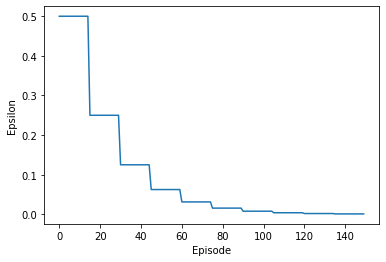

In [92]:
%matplotlib inline

eps = 0.5
epis = 150
epoch = 15

plt.plot([eps*((1-eps)**(i//epoch)) for i in range(epis)])
plt.xlabel('Episode')
plt.ylabel('Epsilon');

### Running Sarsa and Q-learning 

In [93]:
def train(policy, episodes=150):
    if policy == 'sarsa':
        learning_alg = sarsa
    elif policy == 'q-learning':
        learning_alg = q_learning
    else:
        raise ValueError("choose 'sarsa' or 'q-learning'")
    
    epoch_length = 15
    
    # Initialise the rewards vector and state-action values array
    rewards = np.zeros(episodes)
    q_value = np.zeros(Q_DIMS)
    
    print('Training {}...'.format(policy))
    for i in tqdm(range(0, episodes)):
        eps = EPSILON*((1-EPSILON)**(i//epoch_length))
        rewards[i] = learning_alg(q_value, eps=eps)
    
    return q_value, rewards

In [94]:
q_sarsa, rewards_sarsa = train('sarsa')
q_q_learning, rewards_q_learning = train('q-learning')

Training sarsa...



Training q-learning...


IndexError: index 10 is out of bounds for axis 1 with size 10

In [95]:
print('SARSA')
print_optimal_policy(q_sarsa)

SARSA
ask fill prob: 0.00 0.11 0.22 0.33 0.44 0.56 0.67 0.78 0.89 1.00
         flat     b    b    b    b    b    s    s    s    s    s    
        short     h    h    b    h    h    h    h    h    h    h    
         long     h    s    s    s    h    s    s    s    s    s    


<ipython-input-91-7414bf1ba007>:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = np.int(optimal_policy[i,j])


In [ ]:
print('SARSA')
print_optimal_policy(q_sarsa)
print('Q-learning')
print_optimal_policy(q_q_learning)

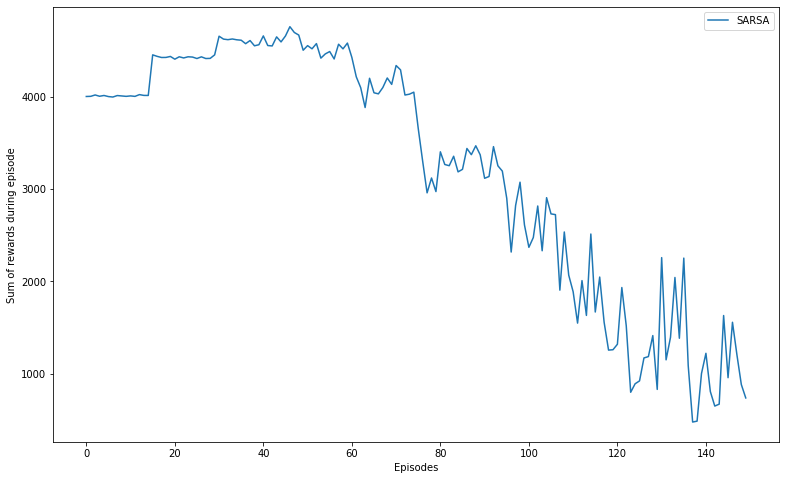

In [96]:
%matplotlib inline
plt.figure(figsize=(13,8))
#plt.plot(rewards_q_learning, label='Q-Learning')
plt.plot(rewards_sarsa, label='SARSA')
plt.xlabel('Episodes')
plt.ylabel('Sum of rewards during episode')
plt.legend();

### Animation of the resulting market making strategy

This code below will run through the dataset, taking actions according to the state-action values learned during the training process above. 

You can choose to use either of the strategies learned by SARSA and Q-learning by assigning them to the `view_strategy` variable.

In [30]:
view_strategy = q_q_learning
#view_strategy = q_sarsa

<IPython.core.display.Javascript object>


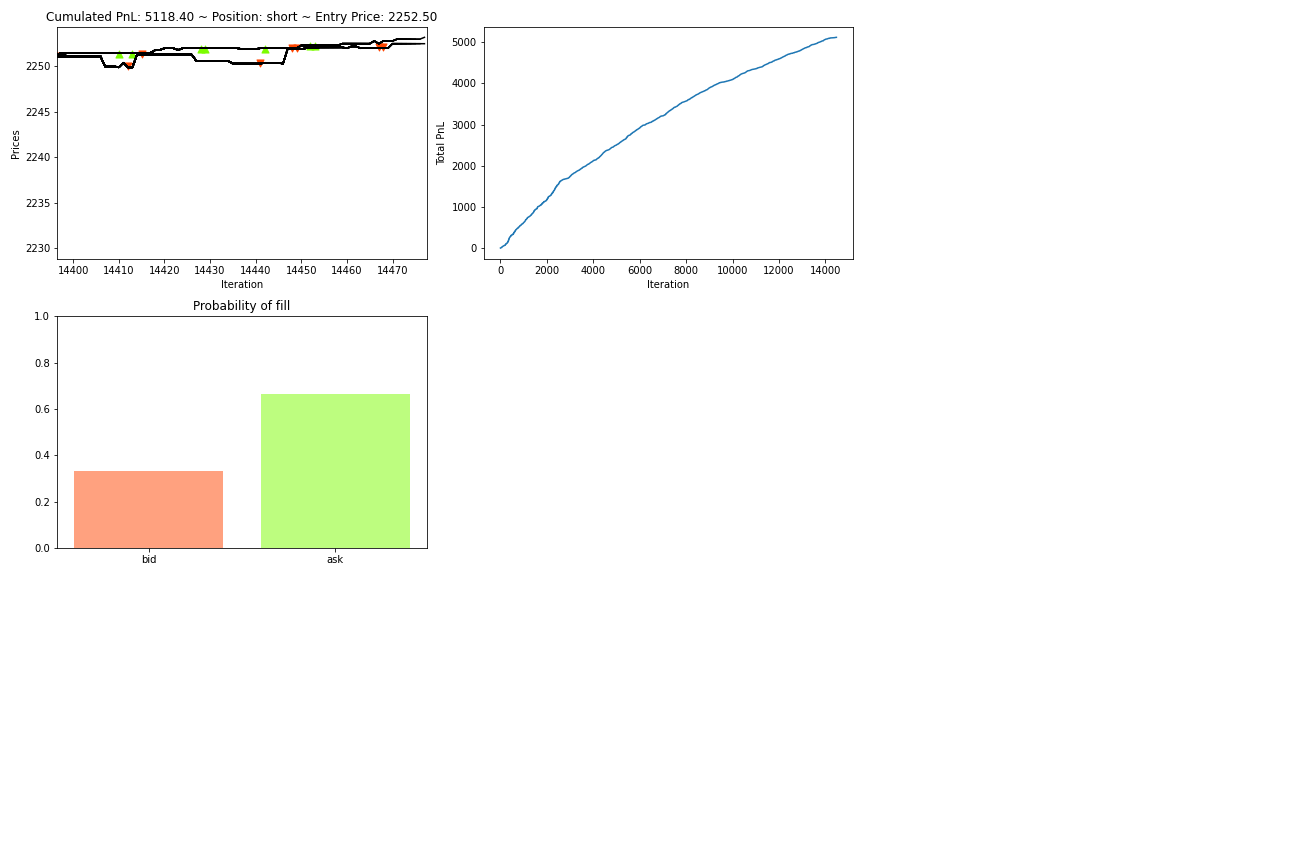

<ipython-input-16-b910d044ca12>:17: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  q_ind = np.int(q * NUM_PROB_STEPS)
<ipython-input-18-254b263a2b05>:57: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for

In [ ]:
%matplotlib nbagg
%matplotlib nbagg

fig = plt.figure(figsize=(12, 8))

gs = GridSpec(2,2) # 2 rows, 2 columns

ax1 = fig.add_subplot(gs[0,0]) # First row, first column
ax2 = fig.add_subplot(gs[0,1]) # First row, second column
ax3 = fig.add_subplot(gs[1,0]) # Second row, first column

bids = []
asks = []
bid_fills = []
xdata = []
pnl = []

done = False
state = get_initial_state(data_generator)
rewards = 0.0
iteration = 0

while iteration < MAX_ITER and not done:
    try:
        start_time = time.time()
        prev_position_name = [name for name, pos in positions.items() if pos == state[0]][0] 
        
        action = np.argmax(view_strategy[state[0], state[1], :])
        try:
            state, reward = step(state, action)
        except StopIteration:
            done = True
            print('Stopped at time step', iteration)
            continue
        iteration += 1
        
        position_name = [name for name, pos in positions.items() if pos == state[0]][0] 
        action_name = [name for name, act in actions.items() if act == action][0]                    
        prices = state[2]
        if state[3] is None:
            entry_price = 'n/a'
        else:
            entry_price = "%.2f" % state[3]
        
        # Cumulative PnL
        if len(pnl) == 0:
            pnl.append(reward)
        else: 
            pnl.append(pnl[-1]+reward)

        bids.append(prices['bid'])
        asks.append(prices['ask'])
        xdata.append(iteration)
        
        # Plot most recent 80 prices
        ax1.plot(xdata, 
                 bids, color = 'black')
        ax1.plot(xdata, 
                 asks, color = 'black')
        ax1.set_ylabel('Prices')
        ax1.set_xlabel('Iteration')
        ax1.set_title('Cumulated PnL: ' + "%.2f" % pnl[-1] + ' ~ '
                     + 'Position: ' + position_name + ' ~ '
                     + 'Entry Price: ' + entry_price)
        ax1.set_xlim([max(0, iteration - 80.5), iteration + 0.5])

        # Plotting actions taken according to the Policy
        if position_name != prev_position_name:
            if action == actions['sell']:
                ax1.scatter(iteration, prices['bid']+0.1, 
                        color='orangered', marker='v', s=50)
            elif action == actions['buy']:
                ax1.scatter(iteration, prices['ask']-0.1, 
                        color='lawngreen', marker='^', s=50)
        
        # Ploting PnL
        ax2.clear()
        ax2.plot(xdata, pnl)
        ax2.set_ylabel('Total PnL')
        ax2.set_xlabel('Iteration')

        # Plotting current probabilities to fill
        q_a = FILL_PROBS[state[1]]
        q_b = 1 - q_a
        performance = [q_b, q_a]

        ax3.clear()
        ax3.bar([0, 1], [q_b, q_a], align='center', alpha=0.5, 
                color=['orangered','lawngreen'])
        ax3.set_xticks([0, 1])
        ax3.set_xticklabels(['bid', 'ask'])
        ax3.set_title('Probability of fill')
        ax3.set_ylim([0, 1])
        fig.tight_layout()
        fig.canvas.draw()
        time.sleep(max(0, 0.5 - (time.time() - start_time)))
        
    except KeyboardInterrupt:
        print('Animation stopped')
        break